# Attention-based Seq2seq Model for Eng2Jap Translation
Guorui Shen, guorui233@outlook.com

Jun 28, 2019.

This notebook is modified from 
+ https://github.com/wanasit/katakana/blob/master/notebooks/Attention-based%20Sequence-to-Sequence%20in%20Keras.ipynb

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from time import time
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20
time_begin = time()
print(sys.path[-1])

Using TensorFlow backend.


/home/io/Desktop/katakana-from-Eng-to-Jap


# Data pre-processing

In [2]:
data = pd.read_csv('../data/joined_titles.csv', header=None)
print(data[0][:2], data[1][:2])
print('------------------------------------------------------------')
data = data.sample(frac=1, random_state=0) # random_state=0 is seed for the random number generator
print(data[0][:2], data[1][:2])
print('------------------------------------------------------------')

# `str.lower()` is to convert a string from uppercase, or even part uppercase to lowercase
utf8_eng = [s.decode('utf-8').lower() for s in data[0]]
utf8_kat = [s.decode('utf-8') for s in data[1]]
print(utf8_eng[:2], utf8_kat[:2])
print('------------------------------------------------------------')

data_size = len(data)
# We will use the first 0-60th %-tile (60% of data for the training
training_utf8_eng  = utf8_eng[data_size*0/100:data_size*60/100]
training_utf8_kat = utf8_kat[data_size*0/100:data_size*60/100]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_utf8_eng = utf8_eng[data_size*60/100:data_size*70/100]
validation_utf8_kat = utf8_kat[data_size*60/100:data_size*70/100]

print('training size is {}'.format(len(training_utf8_eng)))
print('validation size is {}'.format(len(validation_utf8_eng)))

(0    Unschooling
1       Lovosice
Name: 0, dtype: object, 0    アンスクーリング
1      ロヴォシツェ
Name: 1, dtype: object)
------------------------------------------------------------
(11206      Dorogobuzh
80376    Gail Hopkins
Name: 0, dtype: object, 11206       ドロゴブージ
80376    ゲイル・ホプキンス
Name: 1, dtype: object)
------------------------------------------------------------
([u'dorogobuzh', u'gail hopkins'], [u'\u30c9\u30ed\u30b4\u30d6\u30fc\u30b8', u'\u30b2\u30a4\u30eb\u30fb\u30db\u30d7\u30ad\u30f3\u30b9'])
------------------------------------------------------------
training size is 64356
validation size is 10726


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [3]:
def char_int_relation(names):
    """
    input:
        names: list of strings
    return:
        char2int
        int2char
        count
    """
    count = 2
    char2int = {}
    int2char = {1: 'START'}
    for c in set([c for name in names for c in name]):
        char2int[c] = count
        int2char[count] = c
        count += 1
    return char2int, int2char, count

def transform(char2int, utf8_eng_or_kat, vector_size=20):
    """
    Transform a batch of names into their number representations, 
    e.g. [John, Jorge] -> [[81, 23, 47, 64, ...], [81, 23, 55, 22, 42, ...]]
    
    input:
        encoding: encoding dict built by char_int_relation()
        utf8_eng_or_kat: list of strings
        vector_size:
    return:
    """
    transformed_data = np.zeros(
        shape=(len(utf8_eng_or_kat), vector_size), 
        dtype='int')
    for i in range(len(utf8_eng_or_kat)):
        for j in range(min(len(utf8_eng_or_kat[i]), vector_size)):
            transformed_data[i][j] = char2int[utf8_eng_or_kat[i][j]]
    return transformed_data

In [4]:
engchar2int_dict, int2engchar_dict, eng_char_size = char_int_relation(
    utf8_eng)
katchar2int_dict, int2katchar_dict, kat_char_size = char_int_relation(utf8_kat)

print('English character dict size:', eng_char_size)
print('Katakana character dict size:', kat_char_size)

training_encoder_input = transform(
    engchar2int_dict, training_utf8_eng, vector_size=INPUT_LENGTH)
encoded_training_output = transform(
    katchar2int_dict, training_utf8_kat, vector_size=OUTPUT_LENGTH)

print('training_encoder_input', training_encoder_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = transform(
    engchar2int_dict, validation_utf8_eng, vector_size=INPUT_LENGTH)  # INPUT_LENGTH=20
encoded_validation_output = transform(
    katchar2int_dict, validation_utf8_kat, vector_size=OUTPUT_LENGTH) # OUTPUT_LENGTH=20

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

('English character dict size:', 54)
('Katakana character dict size:', 89)
('training_encoder_input', (64356, 20))
('encoded_training_output', (64356, 20))
('encoded_validation_input', (10726, 20))
('encoded_validation_output', (10726, 20))


# Sequence-to-Sequence in Keras

### Encoder / Decoder

In [5]:
"""
In = Input(shape=(input_length, ))

keras.layers.Embedding(input_dim, # Size of the vocabulary
    output_dim,
    embeddings_initializer='uniform', 
    embeddings_regularizer=None, 
    activity_regularizer=None, 
    embeddings_constraint=None, 
    mask_zero=False, 
    input_length=input_length)(In)

    `mask_zero=True` If this is True then all subsequent layers in the model need to support masking 
or an exception will be raised. If mask_zero is set to True, as a consequence, 
index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1.

In: 2D tensor with shape: (batch_size, input_length), here `input_length` is kind of like unrolling timesteps.
return: 3D tensor with shape: (batch_size, input_length, output_dim)
"""
encoder_input_placeholder = Input(shape=(INPUT_LENGTH,))
decoder_input_placeholder = Input(shape=(OUTPUT_LENGTH,))


encoder_input = Embedding(input_dim=eng_char_size, 
                          output_dim=64, 
                          input_length=INPUT_LENGTH, 
                          mask_zero=True)(encoder_input_placeholder)
print('encoder_input', encoder_input)
encoder_full_state_h = LSTM(units=64, 
                            return_sequences=True, # state_final_state_h (False), state_full_state_h (True)
                            return_state=False, # (True) state_final_h and state_final_c
                            unroll=True)(encoder_input)
print('encoder_full_state_h LSTM layer', encoder_full_state_h)

encoder_last = encoder_full_state_h[:,-1,:]
print('encoder_last', encoder_last)

decoder_input = Embedding(input_dim=kat_char_size, 
                          output_dim=64, 
                          input_length=OUTPUT_LENGTH, 
                          mask_zero=True)(decoder_input_placeholder)
decoder_full_state_h = LSTM(units=64,
                       return_sequences=True, 
                       unroll=True
                      )(decoder_input, 
                        initial_state=[encoder_last, encoder_last])

print('decoder_full_state_h', decoder_full_state_h)

('encoder_input', <tf.Tensor 'embedding_1/embedding_lookup:0' shape=(?, 20, 64) dtype=float32>)
('encoder_full_state_h LSTM layer', <tf.Tensor 'lstm_1/transpose_2:0' shape=(?, 20, 64) dtype=float32>)
('encoder_last', <tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>)
('decoder_full_state_h', <tf.Tensor 'lstm_2/transpose_2:0' shape=(?, 20, 64) dtype=float32>)


### Attention Mechanism

**Reference**
+ [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, and subsection 3.1).

<img src="https://suzyi.github.io/images/global-attention.png" alt="rnn unrolling" width=400px/>
where
+ $a_t$ is global align weights.
+ $\bar{h}_s$ is encoder (or source) hidden state.
+ $h_t$ is decoder (or target) hidden state.
+ $\tilde{h}_t$ is defined $\tilde{h}_t = \text{tanh}(W_c[c_t, h_t])$, where $[c_t, h_t]$ is concanate (or hstack) operation.

In [6]:
"""
TimeDistributed: This wrapper applies a layer to every temporal slice of an input.
The input should be at least 3D, and the dimension of index 1 will be considered 
to be the temporal dimension. The input should be of shape (batch_sz, timesteps, input_dim)
TimeDistributed(Dense(8), input_shape=(timesteps, input_dim)) will produce (batch_sz, timesteps, 8)
"""

from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
# dot([(?, 20, 64), (?, 20, 64)], axes=[2, 2]) = (?, 20, 20)
scores = dot([decoder_full_state_h, encoder_full_state_h], axes=[2, 2])
print('scores', scores)
global_align_weights = Activation('softmax', 
                                  name='global_align_weights')(scores) # element-wise
print('global_align_weights', global_align_weights)

# dot([(?, 20, 20), (?, 20, 64)], axes=[2, 1]) = (?, 20, 64)
context = dot([global_align_weights, encoder_full_state_h], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder_full_state_h]) # quite resembles np.hstack((a, b))
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(units=64, activation="tanh"))(
    decoder_combined_context)
print('output', output)
output = TimeDistributed(Dense(
    units=kat_char_size, 
    activation="softmax"))(output)
print('output', output)

('scores', <tf.Tensor 'dot_1/MatMul:0' shape=(?, 20, 20) dtype=float32>)
('global_align_weights', <tf.Tensor 'global_align_weights/truediv:0' shape=(?, 20, 20) dtype=float32>)
('context', <tf.Tensor 'dot_2/MatMul:0' shape=(?, 20, 64) dtype=float32>)
('decoder_combined_context', <tf.Tensor 'concatenate_1/concat:0' shape=(?, 20, 128) dtype=float32>)
('output', <tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 20, 64) dtype=float32>)
('output', <tf.Tensor 'time_distributed_2/Reshape_1:0' shape=(?, 20, 89) dtype=float32>)


In [7]:
model = Model(inputs=[encoder_input_placeholder, decoder_input_placeholder], 
              outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy')

## Training the model

In [8]:
training_decoder_input = np.ones_like(encoded_training_output) # start=1
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]

# convert `encoded_training_output` into one_hot
# kat_char_size=89, shape(encoded_training_output)=(batch_sz, 20)
training_decoder_output = np.eye(kat_char_size)[
    encoded_training_output.astype('int')]
print('training_decoder_output.shape', training_decoder_output.shape)

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.ones_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_output = np.eye(kat_char_size)[
    encoded_validation_output.astype('int')]

('training_decoder_output.shape', (64356, 20, 89))


In [9]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], 
              y=[training_decoder_output],
          validation_data=([validation_encoder_input, 
                            validation_decoder_input],
                           [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)

model.fit(x=[training_encoder_input, training_decoder_input], 
          y=[training_decoder_output],
      validation_data=([validation_encoder_input, 
                        validation_decoder_input],
                       [validation_decoder_output]),
      verbose=2, batch_size=64, epochs=1)
model.save('model.h5')

Train on 64356 samples, validate on 10726 samples
Epoch 1/1
 - 33s - loss: 0.8432 - val_loss: 0.8419


### Testing the model


In [10]:
def generate(name):
    encoder_input = transform(engchar2int_dict, [name.lower()], 20)
    decoder_input = np.zeros(shape=(1, OUTPUT_LENGTH))
    decoder_input[:, 0] = 1 # start token is 1
    for i in range(1, OUTPUT_LENGTH):      
        # output is of shape (1, 20)
        output = model.predict([encoder_input, decoder_input]).argmax(
            axis=2)
        
        # decoder_input is of shape (1, 20) 
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(int2char_dict, sequence):
    name = ''
    for i in sequence:
        if i == 0:
            break
        name += int2char_dict[i]
    return name

def eng_to_kat(name):
    decoder_output = generate(name)
    return decode(int2katchar_dict, decoder_output[0])


common_american_names = ['James', 'John', 'Robert']
for name in common_american_names:
    print(name, eng_to_kat(name))


('James', u'\u30b8\u30a7\u30a4\u30e0\u30ba')
('John', u'\u30b8\u30e7\u30f3')
('Robert', u'\u30ed\u30d0\u30fc\u30c8')


In [11]:
print(eng_to_kat('Banana'))
print(eng_to_kat('Peter Parker'))
print(eng_to_kat('Jonny Snow'))

バナナ
ペーター・パーカー
ジョニー・スノー


# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [12]:
layers = model.layers
for l in layers:
    print('{}\t name:{}'.format(str(l), l.name))

<keras.engine.input_layer.InputLayer object at 0x7f45af468610>	 name:input_2
<keras.engine.input_layer.InputLayer object at 0x7f45af4686d0>	 name:input_1
<keras.layers.embeddings.Embedding object at 0x7f45af468790>	 name:embedding_2
<keras.layers.embeddings.Embedding object at 0x7f45af468710>	 name:embedding_1
<keras.layers.recurrent.LSTM object at 0x7f45af468850>	 name:lstm_2
<keras.layers.recurrent.LSTM object at 0x7f45af468c10>	 name:lstm_1
<keras.layers.merge.Dot object at 0x7f45af468d90>	 name:dot_1
<keras.layers.core.Activation object at 0x7f45af468dd0>	 name:global_align_weights
<keras.layers.merge.Dot object at 0x7f45af468e10>	 name:dot_2
<keras.layers.merge.Concatenate object at 0x7f45af468e50>	 name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x7f45af468490>	 name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x7f45af468550>	 name:time_distributed_2


We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [13]:
align_weights_layer = model.get_layer('global_align_weights') # or model.layers[7]
attention_model = Model(inputs=model.inputs, 
                        outputs=model.outputs + [align_weights_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 89), (None, 20, 20)]


In [14]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['AppleMyungjo'], font_scale=3)

def attent_and_generate(name):
    encoder_input = transform(engchar2int_dict, [name.lower()], 20)
    decoder_input = np.zeros(shape=(1, OUTPUT_LENGTH))
    decoder_input[:, 0] = 1 # start token is 1
    
    for i in range(1, OUTPUT_LENGTH):
        output, align_weights = attention_model.predict(
            [encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = align_weights[0]
        decoded_output = decode(int2katchar_dict, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(name):
    attention_density, katakana = attent_and_generate(name)

    plt.clf()
    plt.figure(figsize=(28,12))
    ax = seaborn.heatmap(attention_density[:len(katakana), :len(name)+1],
        xticklabels=[w for w in name],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'AppleMyungjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


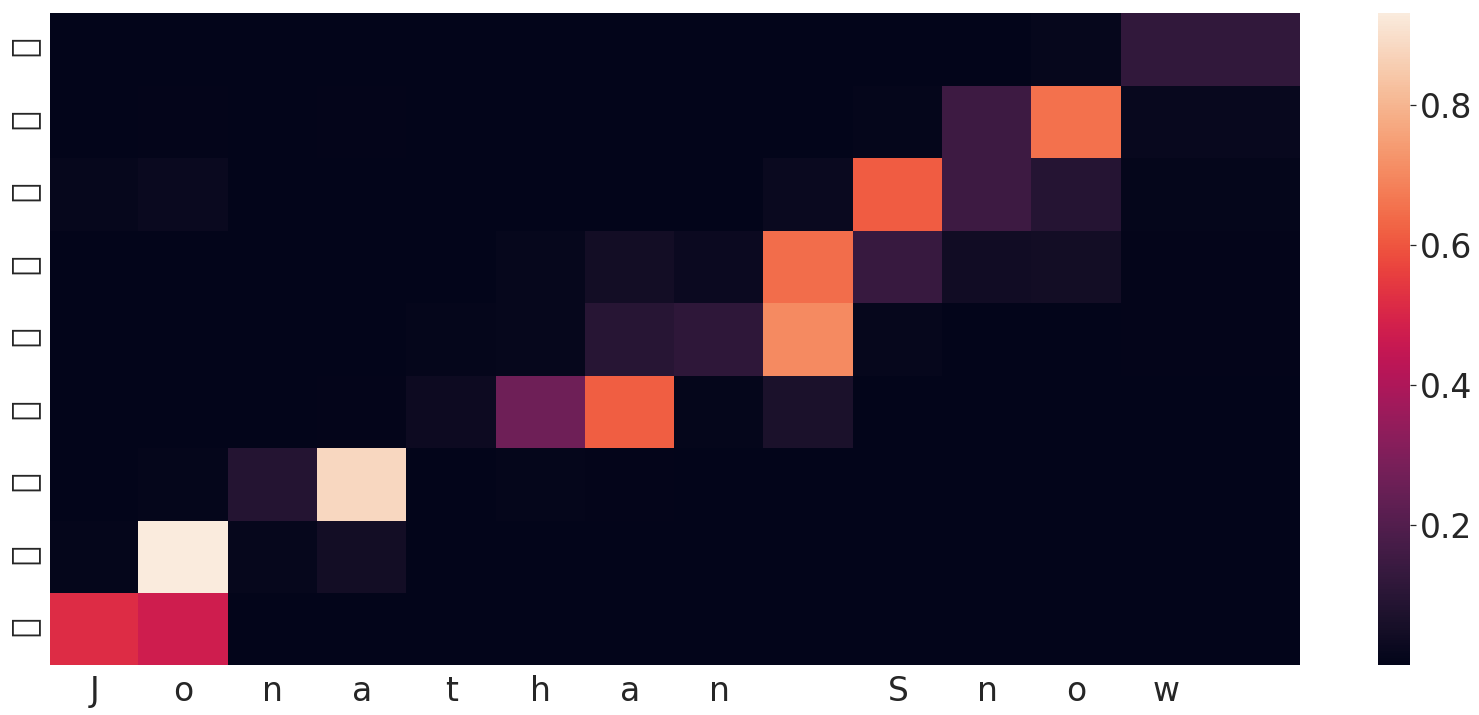

In [15]:
visualize('Jonathan Snow')

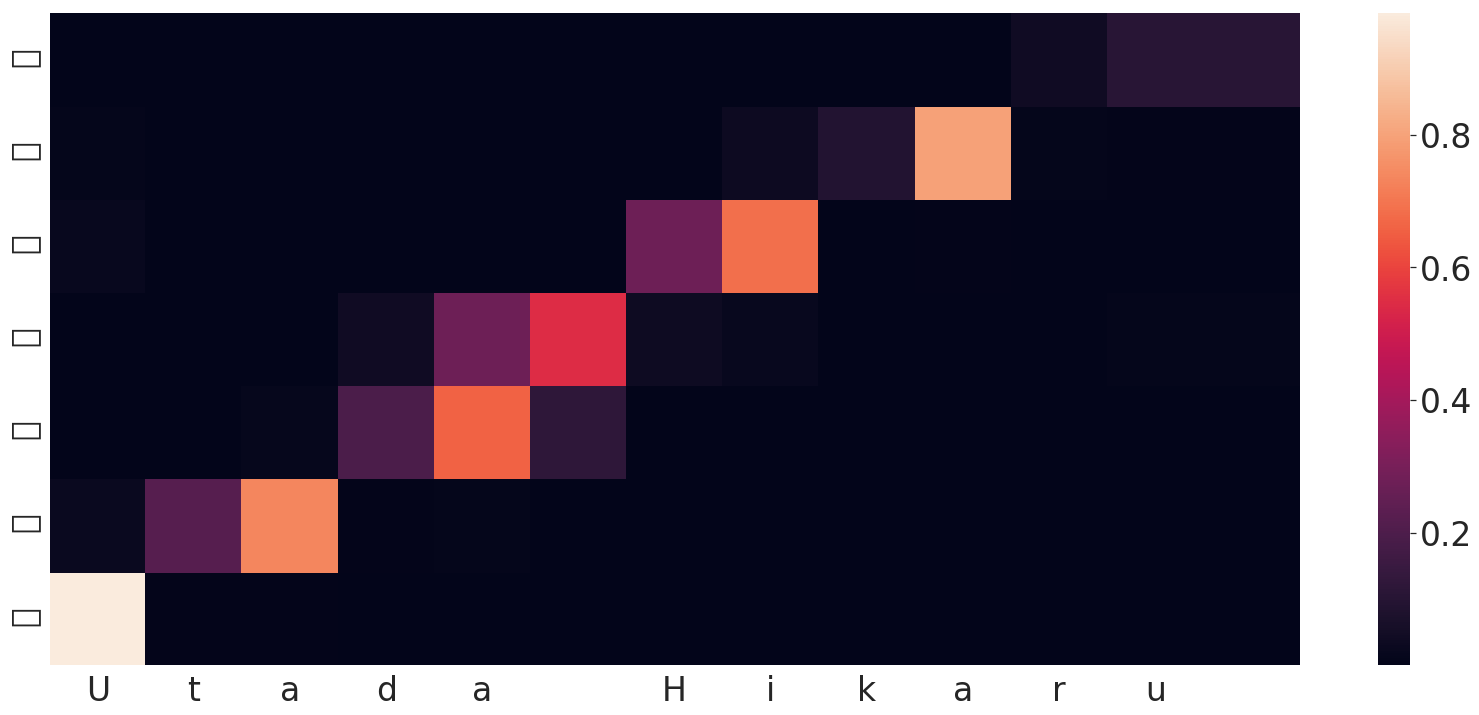

In [16]:
visualize('Utada Hikaru')

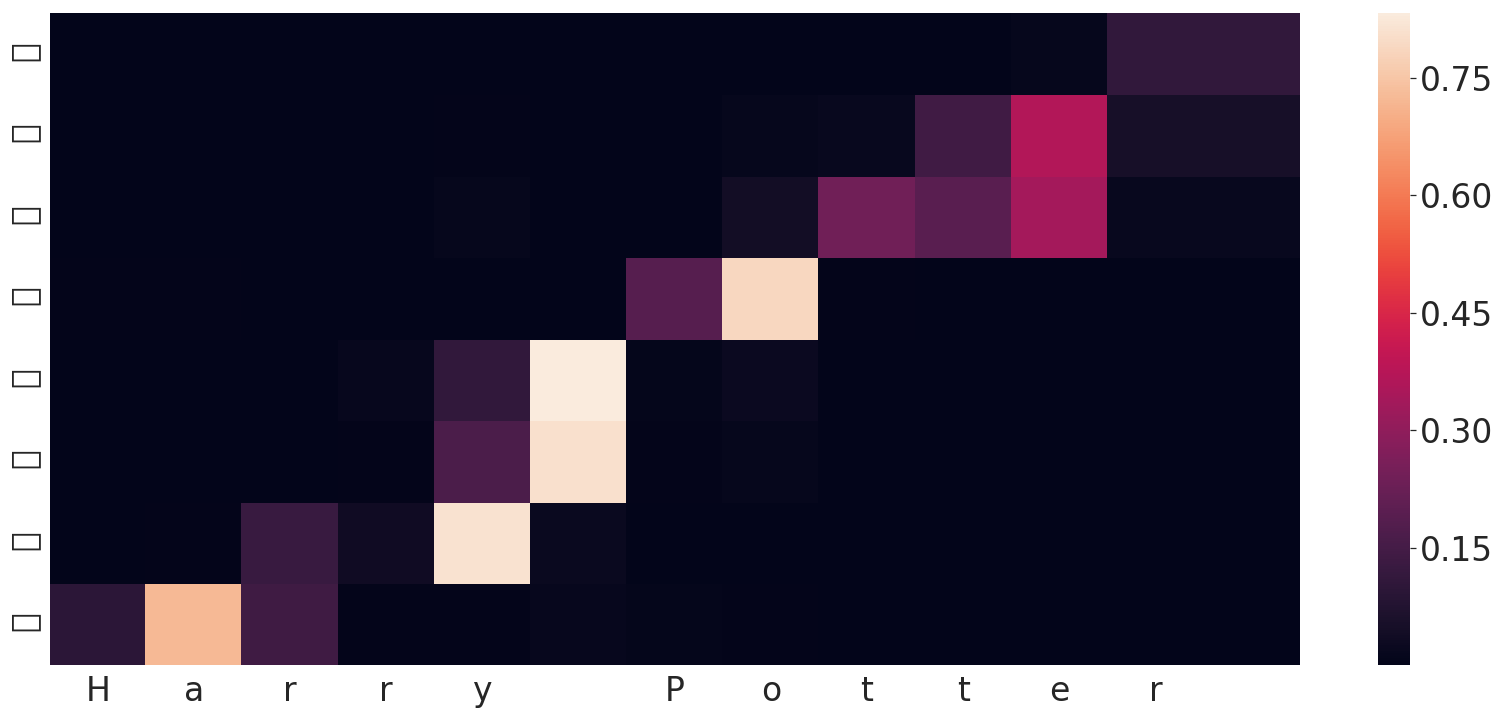

In [17]:
visualize('Harry Potter')

In [18]:
print("This piece of code uses {} minutes.".format((time()-time_begin)/60.))

This piece of code uses 0.838602634271 minutes.
